In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from quantecon.optimize import brent_max, brentq
from interpolation import interp
from numba import njit, float64
from numba.experimental import jitclass
from quantecon import MarkovChain

In [4]:
ifp_data = [
    ('R', float64),              # Interest rate 1 + r
    ('beta', float64),              # Discount factor
    ('gamma', float64),              # Preference parameter
    ('P', float64[:, :]),        # Markov matrix for binary Z_t
    ('y', float64[:]),           # Income is Y_t = y[Z_t]
    ('asset_grid', float64[:])   # Grid (array)
]

@jitclass(ifp_data)
class IFP:

    def __init__(self,
                 r=0.01,
                 beta=0.96,
                 gamma=1.5,
                 P=((0.6, 0.4),
                    (0.05, 0.95)), # Probability to switch between states (incomes)
                 y=(0.0, 2.0),
                 grid_max=16,
                 grid_size=50):

        self.R = 1 + r
        self.beta, self.gamma = beta, gamma
        self.P, self.y = np.array(P), np.array(y)
        self.asset_grid = np.linspace(0, grid_max, grid_size)

        # Recall that we need R β < 1 for convergence.
        assert self.R * self.beta < 1, "Stability condition violated."

    def u_prime(self, c):
        return c**(-self.gamma)

In [5]:
@njit
def euler_diff(c, a, z, sigma_vals, ifp):
    def sigma(a, z):
        return interp(ifp.asset_grid, sigma_vals[:, z], a)

    expect = 0.0
    # Iterate over all states (income markov chain)
    for z_hat in range(len(ifp.P)):
        expect += ifp.u_prime(sigma(ifp.R*(a-c) + ifp.y[z_hat], z_hat)) * ifp.P[z, z_hat]

    return ifp.u_prime(c) - max(ifp.beta * ifp.R * expect, ifp.u_prime(a))

In [6]:
@njit
def K(sigma, ifp):
    sigma_new = np.empty_like(sigma)

    for i, a in enumerate(ifp.asset_grid):
        for z in range(len(ifp.P)):
            res = brentq(euler_diff, 1e-8, a, (a, z, sigma, ifp))
            sigma_new[i, z] = res.root

    return sigma_new

In [7]:
def solve_model_time_iter(model, sigma, tol=1e-4, max_iter=1000, verbose=True, print_skip=25):
    i=0
    error = tol+1

    while i < max_iter and error > tol:
        sigma_new = K(sigma, model)
        error = np.max(np.abs(sigma - sigma_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        sigma = sigma_new

    if error > tol:
        print("Failed to converge!")
    elif verbose:
        print(f"Converged in {i} iterations.")

    return sigma_new

In [12]:
ifp = IFP()
z_size = len(ifp.P)
sigma_init = np.repeat(ifp.asset_grid.reshape(len(ifp.asset_grid), 1), z_size, axis = 1)
sigma_star = solve_model_time_iter(ifp, sigma_init)

Error at iteration 25 is 0.011629589188247191.
Error at iteration 50 is 0.0003857183099458261.

Converged in 60 iterations.


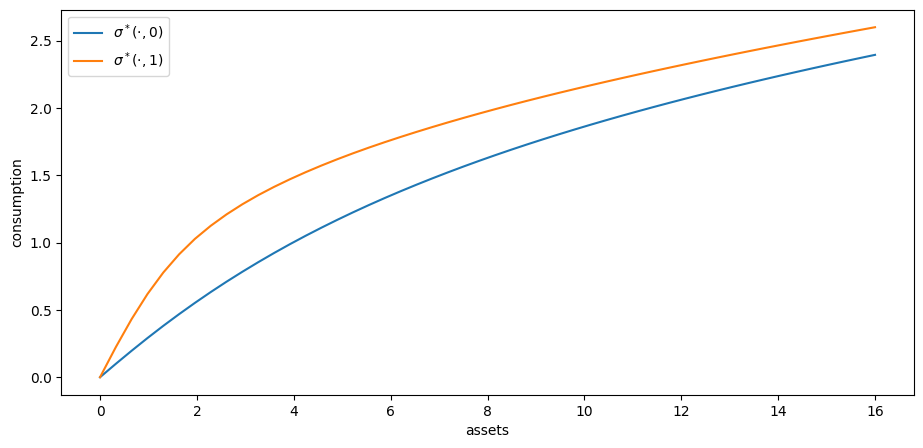

In [13]:
fig, ax = plt.subplots()
for z in range(z_size):
    label = rf'$\sigma^*(\cdot, {z})$'
    ax.plot(ifp.asset_grid, sigma_star[:, z], label=label)
ax.set(xlabel='assets', ylabel='consumption')
ax.legend()
plt.show()